In [89]:
import numpy as np
import random
import scipy.optimize as opt
import scipy.interpolate as intpl
import matplotlib.pyplot as plt
import pdb
import sys
from numba import jit
sys.path.insert(0, "C:\\Users\\utabo\\Documents\\GitHub\\BootCamp2019\\ProblemSets\\ECON\\Week 5")
import parameters as p
import compileparam as compp

In [107]:
#Calculate transitions:
ee=0.95
eu=1-ee
uss=0.05
uu=(uss-(1-uss)*(eu))/uss
ue=1-uu
print(ue)
p.pi=np.array([[ee,eu],[ue,uu]])

0.9500000000000008


In [108]:
def euler(k,p,u):
    r=p.alpha*k**(p.alpha-1)*(1-u)**(1-p.alpha)
    w=(1-p.alpha)*k**p.alpha*(1-u)**(-p.alpha)
    c=(1+r-p.delta)*k+w*(1-u)-k
    err1=p.beta*(1+r)*(-1/c)-(-1/c)
    return err1
def get_SS(bvec_guess,p,uss):
    b_ss= opt.root(euler, bvec_guess,args=(p,uss), tol = 1e-10)
    return b_ss
def kss():
    k_ss = ((1/p.beta - 1 + p.delta) * 0.9**(p.alpha-1) * p.alpha**(-1))**(1/(p.alpha-1))
    return k_ss 
                                                                           
kss()                                                                        

6.490058753339562

In [92]:
def markovsim():
    eps=np.empty([p.numsim])
    eps[0]=0
    for x in range(p.numsim-1):
        ep=np.int_(eps[x])
        eps[x+1]= np.random.uniform(0,1) <= p.pi[ep,1]
    return eps

In [93]:
np.random.seed(386758)   
epsseries=markovsim()
print(np.mean(epsseries))
epsseries=np.int_(epsseries)

0.0515


In [109]:

#====================================================#
#Problem set - Tony Smith
#====================================================#

#Get interest rate
def get_r(kbar,u,p):
    r=p.alpha*kbar**(p.alpha-1)*(1-u)**(1-p.alpha)
    return r

#get wage rate
def get_k(kbar,u,p):
    w=(1-p.alpha)*kbar**p.alpha*(1-u)**(-p.alpha)
    return w

#euler equation:
def utility(x):
    if x>0:
        utils=np.log(x)
    else:
        utils=-(10**8)
    return utils


def negV(kprime,Vcont,eps,p,tt,r,w,kk) :
    V_t_interp0 = intpl.interp1d(p.kgrid,Vcont[:,0], kind='linear', fill_value='extrapolate')
    V_t_interp1 = intpl.interp1d(p.kgrid,Vcont[:,1], kind='linear', fill_value='extrapolate')
    Vprime=np.empty([2])
    #Vprime[0,0]=np.interp(p.kgrid,Vcont[:,0], kprime) #good
    if tt>0:
        #pdb.set_trace()
        Vprime[0]=V_t_interp0(kprime) #good
        Vprime[1]=V_t_interp1(kprime) #bad 
        #Vprime[0]=np.interp( kprime,p.kgrid,Vcont[:,0]) #good
        #Vprime[1]=np.interp(kprime,p.kgrid,Vcont[:,1])#bad 
    else:
        Vprime=np.array([0][0])
    c=(1+r-p.delta)*kk+w*eps-kprime
    EV=sum(Vprime*p.pi[eps,:]) #expected value given transition probs
#     print(Vprime.shape)
#     print(p.pi.shape)
#     print(EV.shape)
    
    value=-1*(utility(c)+p.beta*EV) #negative value of choosing kprime
    return value

#Problem that the consumer solves given kbar:

def vfi(kbar,p,epsseries):
    Vcont=np.zeros([p.numptsk,2])
    pf=np.empty([p.numptsk, 2])
    vopt=np.empty([p.numptsk, 2])
    success=np.empty([p.numptsk, 2])
    r=get_r(kbar,u,p)
    w=get_k(kbar,u,p)
    print(r,w)
    for tt in range(0,p.maxiter):
        for ixe, eps in enumerate(p.epsgrid):
            for ixk, kk in enumerate(p.kgrid):
                #res= opt.minimize_scalar(negV,bracket=(kk*0.00001,kk),args=(Vcont,eps,p,tt,r,w,kk), method='Golden' )          
                res= opt.minimize_scalar(negV,bounds=(0,kk*(1+r-p.delta)+w*eps),args=(Vcont,eps,p,tt,r,w,kk), method='bounded' )
                    
                c=(1+r-p.delta)*kk+w*eps-res.x
                if c<0:
                    print("something went wrong!")
                vopt[ixk,ixe] =-res.fun
                pf[ixk,ixe] =res.x
                success[ixk,ixe] =res.success
        diff=((vopt-Vcont) ** 2).sum()        
        if diff>p.tol:
            Vcont=vopt
        else:
            print("convergence 1 achieved")
            indk=np.empty(p.numsim)
            plt.plot(p.kgrid,pf[:,0])
            plt.plot(p.kgrid,pf[:,1])
            plt.show()
            print(pf.shape)
            print(pf[100,1])
            print(pf[100,0])
            #once we found a solution we want to simulate:
            #np.random.seed(56758)   
            #print(epsseries)
            #epsseries=markovsim()
            #epsseries=np.int_(epsseries)
            indk[0]=6
            for ixN, epsilon in enumerate(epsseries):
                indk[ixN]=np.interp(indk[ixN-1],p.kgrid, pf[:,epsilon])
                #indk[ixN]=intpl.interp1d(indk[ixN-1],p.kgrid, pf[:,epsilon], kind='cubic',fill_value='extrapolate')              
                #indk[ixN]=np.interp(p.kgrid, pf[:,epsilon],kss)
            kss=np.mean(indk[500:p.numsim-1])
            break
    return vopt, pf,kss,indk,success

def aiyagari(kbar,p,epsseries):
    for j in range(0,p.maxiter):
        print("outer loop:")
        print(j)
        vopt, pf,kss,indk,success=vfi(kbar,p,epsseries)
        print("kss-kbar:",abs(kss-kbar))
        print("kss",kss)
        if abs(kss-kbar)>p.tol_outer:            
            kbar=kss
            
        else:
            print("convergence 2 achieved")
            break
    return vopt, pf,kss,indk,success


outer loop:
0
0.10514316838210847 1.2789344458174599
convergence 1 achieved


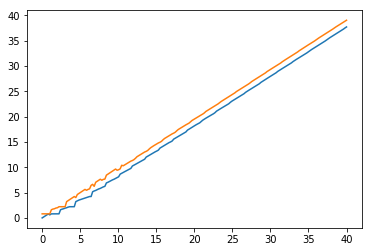

(200, 2)
19.614294238331578
18.26909186705942
kss-kbar: 6.058776162356743
kss 0.4412238376432568
outer loop:
1
0.5881171836543002 0.4855977932274047
convergence 1 achieved


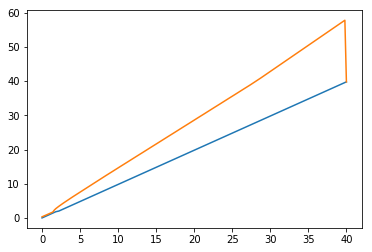

(200, 2)
28.74400083178283
19.89999961720483
kss-kbar: 27.70664420015868
kss 28.14786803780194
outer loop:
2
0.041152903717172104 2.1677033978074
convergence 1 achieved


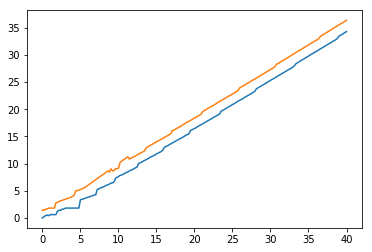

(200, 2)
18.442650965289538
16.5068420308639
kss-kbar: 27.881280311623584
kss 0.2665877261783532
outer loop:
3
0.8119100400029424 0.40504374535814774
convergence 1 achieved


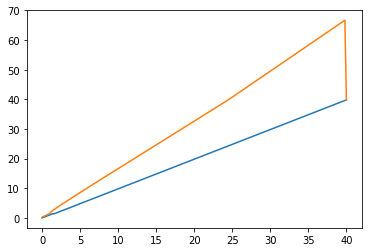

(200, 2)
32.79119878221979
19.899999942284165
kss-kbar: 36.739667003589716
kss 37.00625472976807
outer loop:
4
0.03454216246008936 2.392095556332349
convergence 1 achieved


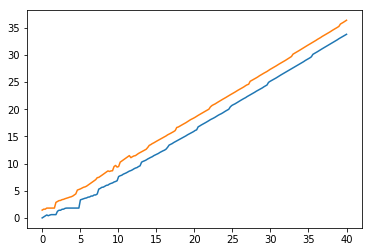

(200, 2)
18.506841261336152
16.078843203262856
kss-kbar: 36.7407557892804
kss 0.2654989404876656
outer loop:
5
0.8140393916830574 0.4044474311243519
convergence 1 achieved


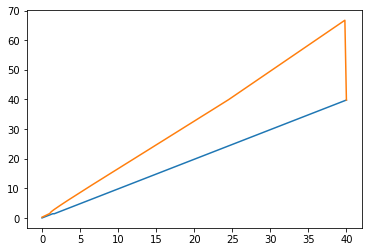

(200, 2)
32.833447081895606
19.89999631063938
kss-kbar: 36.745279195760084
kss 37.01077813624775
outer loop:
6
0.034539460515422844 2.3922008141885462
convergence 1 achieved


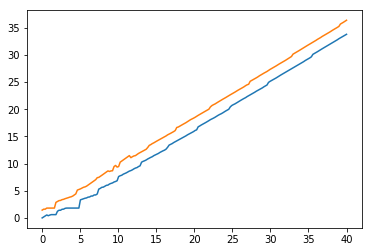

(200, 2)
18.506902883818547
16.078804677374308
kss-kbar: 36.74527839721419
kss 0.2654997390335558
outer loop:
7
0.8140378247104283 0.4044478690508766
convergence 1 achieved


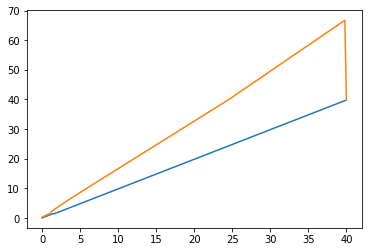

(200, 2)
32.83344464747237
19.89999748375422
kss-kbar: 36.745265539985475
kss 37.01076527901903
outer loop:
8
0.034539468194602026 2.392200515017654
convergence 1 achieved


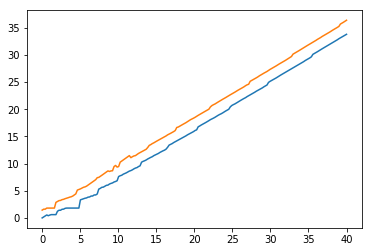

(200, 2)
18.50690272235332
16.07880481557463
kss-kbar: 36.745265451504984
kss 0.265499827514048
outer loop:
9
0.8140376510871822 0.4044479175739652
convergence 1 achieved


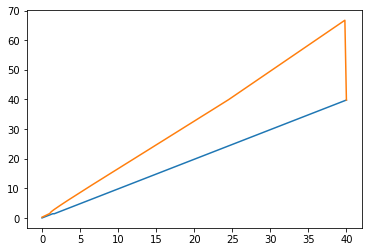

(200, 2)
32.833386872837124
19.89999998763026
kss-kbar: 36.74528163466803
kss 37.01078146218208
outer loop:
10
0.03453945852895771 2.392200891578676
convergence 1 achieved


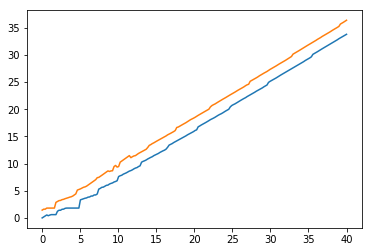

(200, 2)
18.506902926938537
16.07880463798879
kss-kbar: 36.74528172144874
kss 0.265499740733337
outer loop:
11
0.8140378213749857 0.4044478699830441
convergence 1 achieved


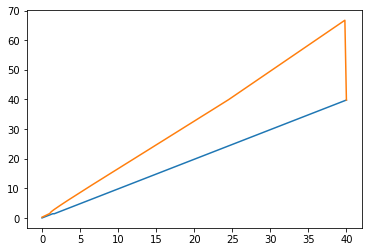

(200, 2)
32.83344432729177
19.899997445912785
kss-kbar: 36.74527529998471
kss 37.01077504071805
outer loop:
12
0.03453946236427555 2.392200742159626
convergence 1 achieved


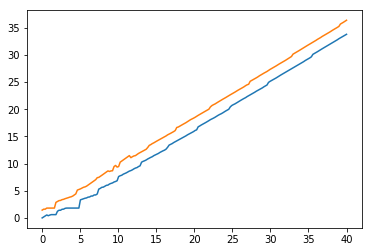

(200, 2)
18.506902846056043
16.07880471477286
kss-kbar: 36.745275211784815
kss 0.265499828933237
outer loop:
13
0.8140376483023408 0.4044479183522546
convergence 1 achieved


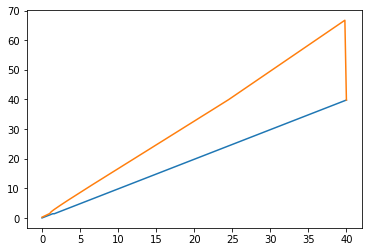

(200, 2)
32.833388273210076
19.899999956035533
kss-kbar: 36.74528586801696
kss 37.010785696950194
outer loop:
14
0.03453945599967814 2.39220099011617
convergence 1 achieved


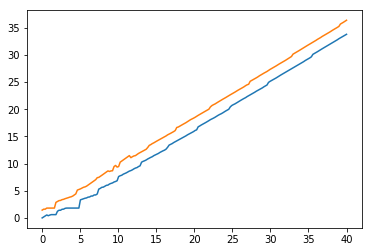

(200, 2)
18.50690297966183
16.078804588297977
kss-kbar: 36.74528595394666
kss 0.26549974300352885
outer loop:
15
0.814037816920239 0.40444787122802733
convergence 1 achieved


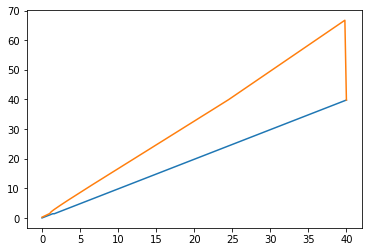

(200, 2)
32.833444401006346
19.89999739537257
kss-kbar: 36.74527552254579
kss 37.01077526554932
outer loop:
16
0.03453946222999161 2.392200747391155
convergence 1 achieved


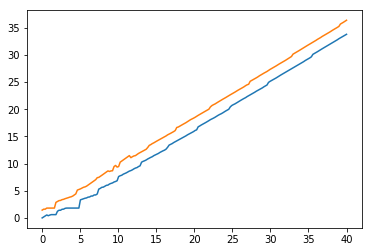

(200, 2)
18.506902848684515
16.078804711098513
kss-kbar: 36.74527543630889
kss 0.265499829240436
outer loop:
17
0.8140376476995312 0.4044479185207238


KeyboardInterrupt: 

In [110]:
p.maxiter=30
u=0.05
vopt_out, pf_out,kss_out,indk,success=aiyagari(6.5,p,epsseries)


In [40]:
print(kss_out)
print(np.std(indk)/np.mean(indk))

0.49990780621332487
0.18837352185406078


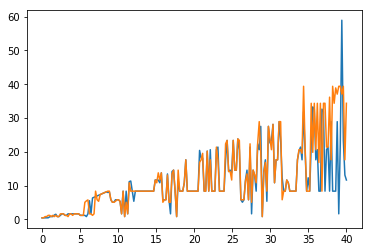

In [41]:
plt.plot(p.kgrid,pf_out[:,0])
plt.plot(p.kgrid,pf_out[:,1])
plt.show()

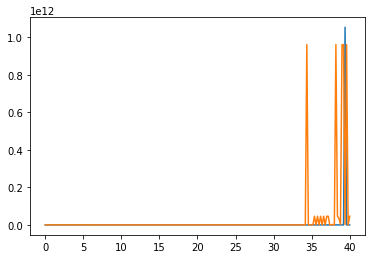

In [42]:
plt.plot(p.kgrid,vopt_out[:,0])
plt.plot(p.kgrid,vopt_out[:,1])
plt.show()